In [3]:
# Importing necessary modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
%matplotlib inline

In [5]:
# Reading the dataset.
dataset = pd.read_excel('./Superstore.xls')
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
dataset.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [7]:
set(dataset['Category'])

{'Furniture', 'Office Supplies', 'Technology'}

## Data Preprocessing

We shall first analyse the time series of Furniture Sales followed by other categories.

In [8]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']

# This shows that we have time-series data of 4 years for furniture sales.
print(furniture['Order Date'].min())
furniture['Order Date'].max()

2014-01-06 00:00:00


Timestamp('2017-12-30 00:00:00')

In [9]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

C:\Users\heman\AppData\Local\Temp\ipykernel_9292\447714323.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture.drop(cols, axis=1, inplace=True)


In [10]:
# furniture data
furniture.sort_values('Order Date')
furniture.isna().sum()

Order Date    0
Sales         0
dtype: int64

In [11]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

## Indexing time-series data 

In [12]:
furniture = furniture.set_index('Order Date')
#furniture = furniture.apply(lambda x: x.set_index('Order Date'))
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [13]:
# Averaging Daily Sales
y = furniture['Sales'].resample('MS').mean()

In [14]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Furniture data time-series visualization

<Axes: xlabel='Order Date'>

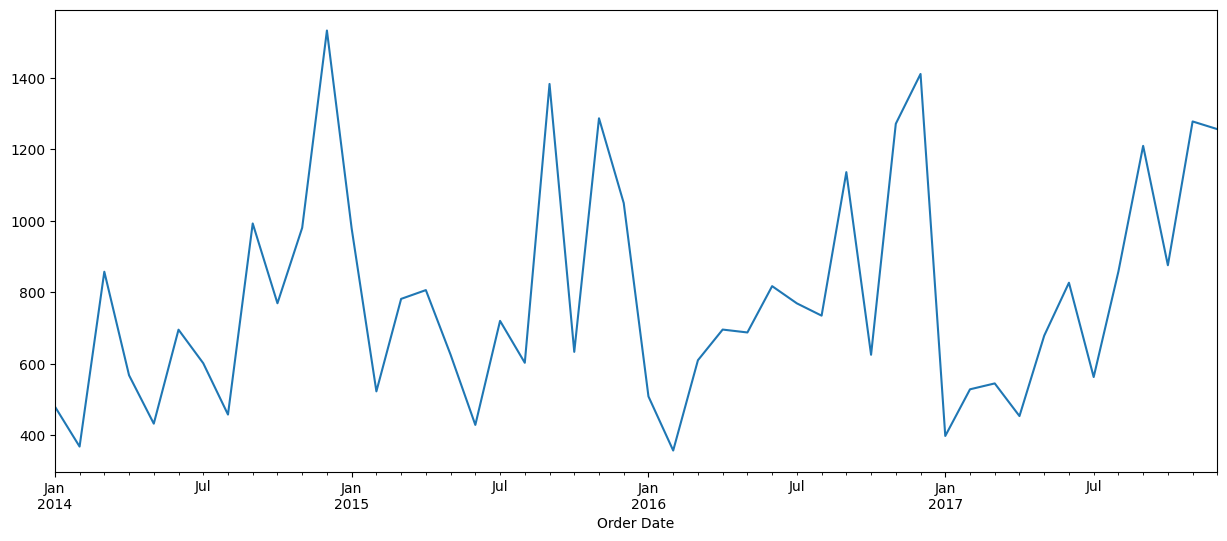

In [15]:
y.plot(figsize=(15, 6))

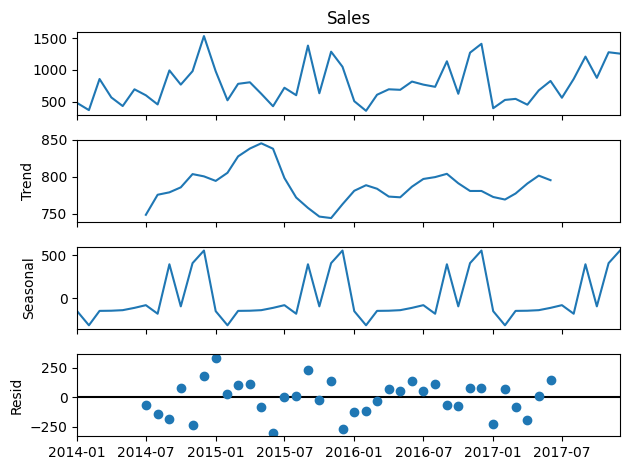

In [16]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

The above plot shows that the sales of furniture is highly unstable with seasonality and trend easily observable.

## Time Series forecasting with ARIMA Model

ARIMA models are donated with the notation: ARIMA (p, d, q) where:
* p denotes seasonality
* d denotes trend
* q denotes noise in data

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal components of the series.

Trend Components:
* p denotes Trend autoregression order
* d denotes Trend difference order
* q denotes Trend moving average order

Seasonality Components:
* p denotes Seasonal autoregressive order.
* d denotes Seasonal difference order.
* q denotes Seasonal moving average order.
* m denotes the number of time steps for a single seasonal period.

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Few parameter combinations are:')
print('{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('{} x {}'.format(pdq[2], seasonal_pdq[2]))

Few parameter combinations are:
(0, 0, 1) x (0, 0, 1, 12)
(0, 1, 0) x (0, 1, 0, 12)


Now that we've generated all possible parameters for our SARIMA model, we shall find out the best parameter to train the model on it finally. :)

SARIMA stands for **Seasonal AutoRegressive Integrated Moving Average** model which is an extension of ARIMA model used in modeling the seasonality component as well. So, we need not to make time-series stationary (non-seasonal) first before forecasting. 

In [18]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205915


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1457.5412534942598
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:477.7170130919703
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:302.27028997935736
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:497.2314433418338


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1179.6903776415356
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:304.24882803033336
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:720.9252270758095


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2621.5327370301484
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:466.56074298091517
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:291.62613896732915


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:499.5634719720483


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2556.28914808803
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:319.9884876946868
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:291.8725576454926
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:677.8947668259312


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1295.1066017507496
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:486.6378567269187
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:304.9671228167952
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:497.7889663004408


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:728.7423709983838
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:306.9113200151447
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:649.9056176817271
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:2522.1295077775058
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:458.8705548482891


C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:279.5806233371438
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:486.18329774426627


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1487.3668521930545
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:310.75743684173415


C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:281.5576621461241
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067713


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:1424.5197735140755
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:479.4632147852136
ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:304.20776751609657
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:480.92593679351955


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1286.223107220303
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:304.46646750846116
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:304.5842692143826
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:665.7794442186537


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:2502.8423930227573
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:468.3685195814153
ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:293.34221939659676
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:482.5763323877216


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:2459.1464756931696
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:306.0156002128098


C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:293.7513188151047
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:5.301648956230562e+85
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:479.2003422281135


C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:300.2130611619097
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:475.34036587842417


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1390.8888534764546
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:300.62709013454116
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:302.3264992504886
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:649.0318019835676


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:756.3369428088988
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:460.4762687610702


C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:281.38730069393813
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:469.5250354660784


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:432.0463723403444
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:297.7875439541562


C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:283.36610163109253


We got the lowest AIC value: 297.788 for ARIMA(1, 1, 1)x(1, 1, 0, 12). We shall use these best params in our model.

Here, the **Akaike information criterion (AIC)** is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

AIC estimates the relative amount of information lost by a given model: the less information a model loses (less AIC value), the higher the quality of that model.

In [19]:
# Training the ARIMA model.
model = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False,
                                            enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


In [24]:
results.plot_diagnostics(figsize=(15, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1500x800 with 0 Axes>

The above plots suggest that the Model Residuals are nearly Normally Distributed.

## Validating the model forecasts

To validate the model results, we compare the actual sales with the predicted sales of the time series data starting
from 2017/01/01 till the end of the data.

            lower Sales  upper Sales
Order Date                          
2017-01-01   204.676228   895.518070
2017-02-01    31.859628   721.912879
2017-03-01   296.216021   985.551802
2017-04-01   373.138060  1061.818283
2017-05-01   347.351367  1035.430262
2017-06-01   471.969147  1159.494482
2017-07-01   433.445399  1120.459466
2017-08-01   385.912233  1072.452655
2017-09-01   806.828560  1492.928957
2017-10-01   291.097906   976.788437
2017-11-01   948.687577  1633.995405
2017-12-01  1074.694441  1759.644116


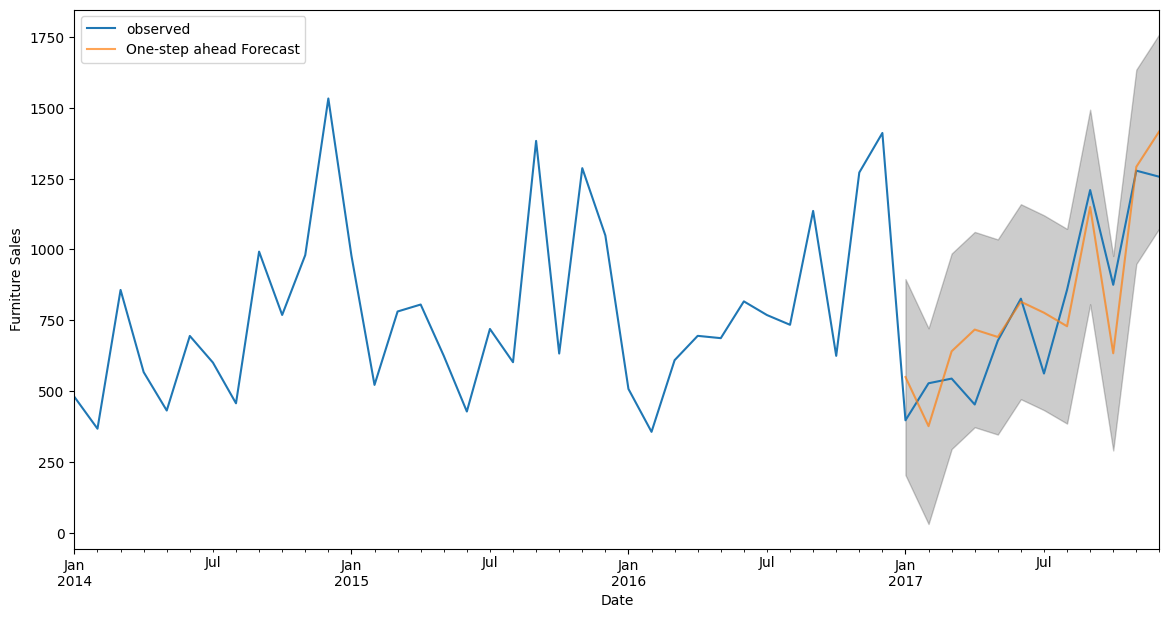

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The above plot demonstrates that the predicted values alligns well with the true values capturing an upward seasonality. Now, we calculate the Mean Square Error of our predicted values wrt the orignal values.

In [26]:
y_predicted = pred.predicted_mean
y_true = y['2017-01-01':]
mse = ((y_predicted - y_true)**2).mean()
print('Mean Square Error is:', round(mse, 4))

Mean Square Error is: 22993.5724


In [27]:
print('Root Mean Square Error is:', np.sqrt(mse))

Root Mean Square Error is: 151.63631617422513


## Future Forecasts

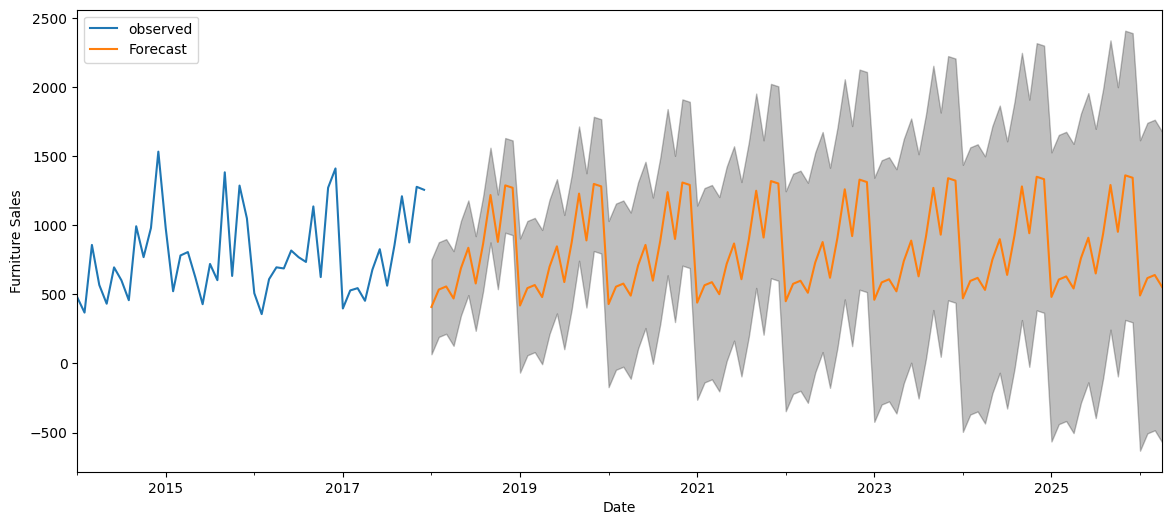

In [28]:
# Forecasting the future (out of sample) values.
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Here, note that the confidence interval is increasing as we move further into the future. The model becomes less confident in predicting the values as we move ahead.

Our data has 3 categories: 'Furniture', 'Office Supplies' and, 'Technology'. Let's compare the 'Furniture' and 'Office Supplies' time series.

## Furniture vs Office Supplies

In [29]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']
office = dataset.loc[dataset['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [30]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

C:\Users\heman\AppData\Local\Temp\ipykernel_9292\3312276940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture.drop(cols, axis=1, inplace=True)
C:\Users\heman\AppData\Local\Temp\ipykernel_9292\3312276940.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  office.drop(cols, axis=1, inplace=True)


Now, let's merge both the time series for comparison.

In [31]:
store = furniture.merge(office, on='Order Date', how='inner')
store.rename(columns={'Sales_x': 'Furniture Sales', 'Sales_y': 'Office Sales'}, inplace=True)
store.head()

,Order Date,Furniture Sales,Office Sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


## Visualizing Furniture vs Office Sales time series

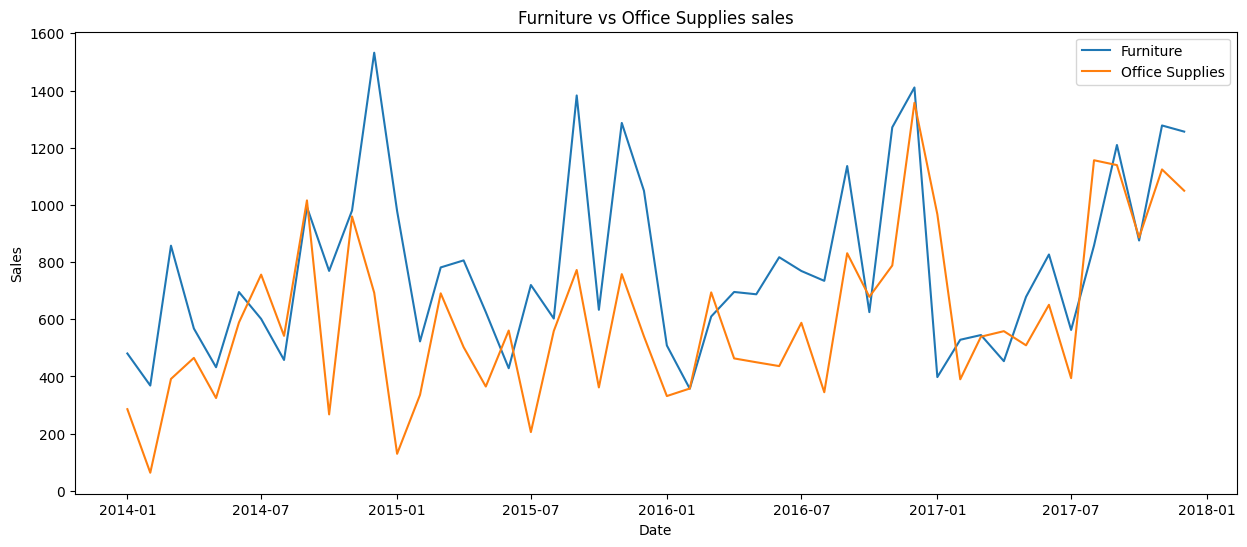

In [32]:
plt.figure(figsize=(15, 6))
plt.plot(store['Order Date'], store['Furniture Sales'], label='Furniture')
plt.plot(store['Order Date'], store['Office Sales'], label='Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies sales')
plt.legend()

### Few Observations:

* The above plot clearly shows that both furniture and office supplies exhibit similar seasonality component.
* The sales are generally low at the beginning of every year as evident from decreasing line slope at the onset of year 2014, 2015, 2016 etc. 
* Also, monthly average sales of furniture is higher than that of office supplies. It's probably because cost of furniture is much more as compared to office utilities.

But there are few instances in the time series where office supply sales surpass furniture. It is mainly in **July 2014** for the first time in the dataset.